In [1]:
import random
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from keras.datasets import mnist
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Load the data

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# x_train[0]

In [4]:
#Convert int -> float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [5]:
# x_train[0]

In [6]:
#Normalize data from 0-255 to 0-1
x_train /= 255
x_test /= 255

In [7]:
# x_train[0]

In [8]:
# Make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

In [9]:
#Each pair gets 1 label
#Pair = 2 images put together into one list, eg: pairs_train[i][0] & pairs_train[i][1].
#Label = 1 if pairs_train[i][0] and pairs_train[i][1] same digit, 0 if different digit.

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [10]:
# pairs_train[0][1]

Same? - 1


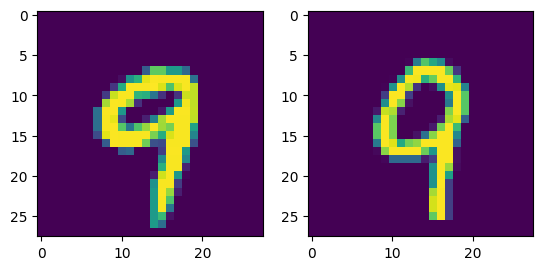

In [11]:
# Take a peek at the data
x = 232
plt.subplot(1, 2, 1)
plt.imshow(pairs_train[x,0])
plt.subplot(1, 2, 2)
plt.imshow(pairs_train[x,1])

print("Same? -", labels_train[x])

UNSHARED WEIGHTS

In [12]:
# Weights not shared

sub_network_1 = Sequential()
sub_network_1.add(Flatten(input_shape=(28,28)))
sub_network_1.add(Dense(128, activation='relu'))

sub_network_2 = Sequential()
sub_network_2.add(Flatten(input_shape=(28,28)))
sub_network_2.add(Dense(128, activation='relu'))

network_merge_layer = Concatenate()([sub_network_1.output, sub_network_2.output])
network_dense_layer = Dense(1, activation="sigmoid")(network_merge_layer)

model = Model(inputs=[sub_network_1.input, sub_network_2.input], outputs=network_dense_layer)

In [13]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flatten_input (InputLayer)     [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1_input (InputLayer)   [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['flatten_input[0][0]']          
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['flatten_1_input[0][0]']        
                                                                                              

In [14]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs= 10)

Epoch 1/10
7500/7500 [==============================] - 31s 3ms/step - loss: 0.6947 - accuracy: 0.5067
Epoch 2/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.6933 - accuracy: 0.5048
Epoch 3/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.6930 - accuracy: 0.5079
Epoch 4/10
7500/7500 [==============================] - 25s 3ms/step - loss: 0.6929 - accuracy: 0.5076
Epoch 5/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.6926 - accuracy: 0.5110
Epoch 6/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.6922 - accuracy: 0.5088
Epoch 7/10
7500/7500 [==============================] - 23s 3ms/step - loss: 0.6917 - accuracy: 0.5143
Epoch 8/10
7500/7500 [==============================] - 23s 3ms/step - loss: 0.6910 - accuracy: 0.5163
Epoch 9/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.6904 - accuracy: 0.5181
Epoch 10/10
7500/7500 [==============================] - 28s 4ms/step - l

In [14]:
#This does not perform so well, it does better than randomly assuming whether or not 2 pictures are the same. But its not so good.
#It is missing something.

Using Keras functions to manipulate the layers more. How is this different to before? Model has half the number of parameters to before since it is sharing the parameters.

In [15]:
input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Concatenate()([dense1, dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)

In [16]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 model_1 (Functional)           (None, 128)          100480      ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 256)          0           ['model_1[0][0]',          

In [17]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.6946 - accuracy: 0.5014
Epoch 2/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.6932 - accuracy: 0.5044
Epoch 3/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.6931 - accuracy: 0.5099
Epoch 4/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.6930 - accuracy: 0.5029
Epoch 5/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.6929 - accuracy: 0.5058
Epoch 6/10
7500/7500 [==============================] - 20s 3ms/step - loss: 0.6926 - accuracy: 0.5078
Epoch 7/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.6922 - accuracy: 0.5111
Epoch 8/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.6919 - accuracy: 0.5084
Epoch 9/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.6914 - accuracy: 0.5114
Epoch 10/10
7500/7500 [==============================] - 27s 4ms/step - l

In [18]:
#Only works a little bit better than the previous model.

Using Siamese Network for OSL.

In [19]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)

In [20]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 model_3 (Functional)           (None, 128)          100480      ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model_3[0][0]',          

In [21]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs=10)

Epoch 1/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.5099 - accuracy: 0.7517
Epoch 2/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.4308 - accuracy: 0.8068
Epoch 3/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.4241 - accuracy: 0.8102
Epoch 4/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.4208 - accuracy: 0.8116
Epoch 5/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.4190 - accuracy: 0.8132
Epoch 6/10
7500/7500 [==============================] - 23s 3ms/step - loss: 0.4169 - accuracy: 0.8148
Epoch 7/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.4151 - accuracy: 0.8149
Epoch 8/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.4132 - accuracy: 0.8162
Epoch 9/10
7500/7500 [==============================] - 21s 3ms/step - loss: 0.4127 - accuracy: 0.8164
Epoch 10/10
7500/7500 [==============================] - 22s 3ms/step - l